In [1]:
import re
import os
import textwrap
from typing import Dict, List, Tuple, Union, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preprocessing GEE -> single .csv

In [7]:
# Function to infer a year from a label (e.g., filename)
def _infer_year(label: str) -> str:
    """Infer a year string from a filename/label; fall back to label if no 4-digit year is found."""
    m = re.search(r'(\d{4})', os.path.basename(str(label)))  # Look for a 4-digit year
    return m.group(1) if m else str(label)  # Return the year if found, otherwise return the label as a string

# Function to ensure that the input is a DataFrame, reading from a file if necessary
def _ensure_dataframe(df_like: Union[pd.DataFrame, str]) -> pd.DataFrame:
    """If df_like is a path, read it; otherwise return as-is."""
    if isinstance(df_like, str):  # If input is a file path
        return pd.read_csv(df_like)  # Read the file as a DataFrame
    return df_like  # Otherwise return the DataFrame as-is

# Function to wrap long text labels (for legends, etc.) to a fixed width
def _wrap_label(s: str, width: int = 18, max_lines: int = 2) -> str:
    """Wrap legend text to a fixed width and at most `max_lines` lines (no fontsize change)."""
    lines = textwrap.wrap(s, width=width, break_long_words=False, break_on_hyphens=False)  # Wrap text
    if len(lines) > max_lines:  # If the text exceeds max_lines, condense it into max_lines
        lines = lines[:max_lines-1] + [' '.join(lines[max_lines-1:])]  # Join remaining lines into the last one
    return "\n".join(lines)  # Join the wrapped lines into a single string

# Main function to plot the clustered, stacked bar chart
def plot_clustered_stacked(
    data: Union[Dict[str, Union[pd.DataFrame, str]], List[Tuple[Union[pd.DataFrame, str], str]], pd.DataFrame],
    id_col: Union[int, str] = 0,  # Default column for watershed IDs (0-based index or column name)
    categories: Optional[List[str]] = None,  # Optional list of categories (land-cover types) to plot
    title: Optional[str] = None,  # Optional title for the plot
    figsize: tuple = (20, 8),  # Size of the figure
    legend_outside: bool = True,  # Whether to position the legend outside the plot
):
    """
    Create a clustered, stacked bar chart where each cluster corresponds to a watershed ID. Takes in multiple dataframes with titles that end with _{watershed_ID}.
    DF's must be structured as follows: watershed_ID,landcover1,lancover2,etc.
    The bars are stacked by land-cover categories, and each cluster is ordered chronologically by year.
    """
    # Normalize inputs into a dict[str -> DataFrame] (handle different input formats)
    if isinstance(data, pd.DataFrame):
        dfs = {"single": data.copy()}  # If data is a DataFrame, wrap it in a dictionary
        labels = ["single"]
    elif isinstance(data, dict):
        dfs = {k: _ensure_dataframe(v).copy() for k, v in data.items()}  # If it's a dictionary of DataFrames
        labels = list(dfs.keys())
    else:  # Assume data is a list of tuples
        dfs = {lbl: _ensure_dataframe(df) for df, lbl in data}
        labels = list(dfs.keys())

    # Infer years from the labels and sort them chronologically
    raw_years = [_infer_year(lbl) for lbl in labels]
    def _to_int_or_inf(y):
        try:
            return int(y)  # Try to convert to an integer
        except Exception:
            return float('inf')  # If conversion fails, return infinity for sorting
    order_idx = sorted(range(len(raw_years)), key=lambda i: _to_int_or_inf(raw_years[i]))  # Sort years
    labels = [labels[i] for i in order_idx]
    years  = [raw_years[i] for i in order_idx]
    dfs    = {lbl: dfs[lbl] for lbl in labels}

    # Function to resolve the ID column name (either by index or name)
    def _resolve_id_col(df: pd.DataFrame, id_col_spec: Union[int, str]) -> str:
        if isinstance(id_col_spec, int):
            return df.columns[id_col_spec]  # If it's an index, return the column name at that index
        return id_col_spec  # If it's a name, return it directly

    sample_df = next(iter(dfs.values()))  # Get the first DataFrame to inspect columns
    id_col_name = _resolve_id_col(sample_df, id_col)  # Resolve the actual column name for watershed IDs

    # Build union of all watershed IDs across frames and preserve the desired order
    all_ids = set()
    for df in dfs.values():
        if id_col_name not in df.columns:
            id_col_name = _resolve_id_col(df, id_col)  # Ensure the correct column is used
        if id_col_name not in df.columns:
            raise ValueError(f"Could not find id_col '{id_col}' in dataframe with columns: {list(df.columns)}")
        all_ids.update(df[id_col_name].astype(str).tolist())  # Collect all unique IDs

    # ----- COMMENT OUT OR CHANGE FOR UNIQUE IDs -------

    # Define the desired order of IDs (this is the order you want to display on the plot)
    desired_order = [
        '6120191830', '6120208780', '6120254390', '6120288400',
        '6121039290', '6121047290', '6121051790', '6121064220',
        'Quinuas', 'Zhurucay'
    ]
    all_ids = [i for i in desired_order if i in all_ids]  # Keep only the IDs present in the data, in the desired order

    # Map the numeric labels for each watershed ID
    id_display_map = {
        '6120191830': '1',
        '6121039290': '2',
        '6120208780': '3',
        '6121047290': '4',
        '6121051790': '5',
        '6120254390': '6',
        '6121064220': '7',
        '6120288400': '8',
        # "Quinuas" and "Zhurucay" remain unchanged
    }

    # Map display labels for the x-axis (using the numeric labels for the first 8 IDs)
    display_ids = [id_display_map.get(wsid, wsid) for wsid in all_ids]

    # -------- END UNCOMMENT -------- #

    # Prepare the categories (land-cover types)
    if categories is None:
        numeric_cols = [c for c in sample_df.columns if c != id_col_name and pd.api.types.is_numeric_dtype(sample_df[c])]
        categories = numeric_cols
    if not categories:
        raise ValueError("No categories to plot. Provide categories=... or ensure numeric columns exist.")

    # Prepare the DataFrames for plotting (ensure all categories are included)
    prepared = []
    for _, df in dfs.items():
        df = df.copy()
        df[id_col_name] = df[id_col_name].astype(str)  # Ensure IDs are strings
        keep_cols = [id_col_name] + [c for c in categories if c in df.columns]  # Keep only relevant columns
        df = df[keep_cols]
        for c in categories:
            if c not in df.columns:  # If a category is missing, fill with zero
                df[c] = 0.0
        df = df.set_index(id_col_name).reindex(all_ids).fillna(0.0)  # Reindex to desired order
        prepared.append(df[categories])

    # Define the positions for the bars (X-axis positions)
    n_clusters = len(all_ids)
    n_years = len(prepared)
    x = np.arange(n_clusters)  # X positions for the bars
    total_width = 0.8
    bar_width = total_width / max(1, n_years)  # Adjust the width of bars if there are multiple years
    offsets = np.linspace(-total_width/2 + bar_width/2, total_width/2 - bar_width/2, n_years)  # Offsets for each year

    # Create the figure and axes for plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Define consistent colors for categories
    cmap = plt.get_cmap('tab20')  # Use a color map for distinct colors per category
    cat_colors = {cat: cmap(i % cmap.N) for i, cat in enumerate(categories)}

    # Handles for the legend
    cat_handles = {cat: None for cat in categories}

    # Compute max height for the bars (for spacing and label placement)
    global_max = 0.0
    for df_year in prepared:
        global_max = max(global_max, (df_year.sum(axis=1)).max())  # Find the maximum value to scale the plot
    if global_max <= 0:
        global_max = 1.0

    # Plot each bar (sorted by magnitude for stacking)
    for j, df_year in enumerate(prepared):
        for i, wsid in enumerate(all_ids):
            vals = df_year.loc[wsid].to_dict()  # Get the values for each watershed ID
            sorted_cats = sorted(categories, key=lambda c: vals.get(c, 0.0), reverse=True)  # Sort categories by value
            bottom = 0.0
            for cat in sorted_cats:
                h = float(vals.get(cat, 0.0))  # Get the height for each category
                if h <= 0:
                    continue
                b = ax.bar(x[i] + offsets[j], h, bar_width, bottom=bottom,  # Plot the bar segment
                           color=cat_colors[cat], edgecolor='none',
                           label=cat if cat_handles[cat] is None else None)
                if cat_handles[cat] is None and len(b) > 0:
                    cat_handles[cat] = b[0]  # Store the first handle for the legend
                bottom += h  # Update the bottom for the next segment

            # Add year label beneath each bar
            ax.text(x[i] + offsets[j], -0.055 * global_max, years[j],
                    ha='center', va='top', fontsize=8, rotation=90,
                    clip_on=False, zorder=5)

    # Set axis labels and formatting
    ax.set_xticks(x)
    ax.set_xticklabels(display_ids, rotation=45, ha='right', fontsize=12)  # Set the X-axis labels (ID or numeric)
    ax.set_ylabel("Fraction of watershed area", fontsize=12)

    # Adjust the axis limits and style
    ax.set_ylim(bottom=-0.12 * global_max)
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_position(('outward', 18))  # Adjust the position of the bottom axis
    ax.tick_params(axis='x', length=0)  # Remove ticks on the X-axis

    # Title of the plot
    if title is None:
        plt.title("No title inserted", fontsize=16)
    else:
        plt.title(title, fontsize=16)

    # Reserve room for the legend
    fig.subplots_adjust(right=0.84, bottom=0.22)

    # Create the legend (wrapped labels for land-cover types)
    handles = [cat_handles[c] for c in categories if cat_handles[c] is not None]
    labels = [_wrap_label(c, width=20, max_lines=2) for c in categories if cat_handles[c] is not None]

    if handles:
        ax.legend(
            handles, labels,
            title="Land-cover type",
            loc='center left',
            bbox_to_anchor=(1.0025, 0.5),  # Place the legend outside the plot
            borderaxespad=0.0,
            frameon=True,
            fontsize=12,  # Unchanged text size
            title_fontsize=12,
            handlelength=1.8,
            handletextpad=0.6,
            labelspacing=0.6
        )

    # Final tweaks and show the plot
    ax.margins(x=0.02)
    ax.grid(axis='y', linestyle=':', linewidth=0.5)
    plt.show()

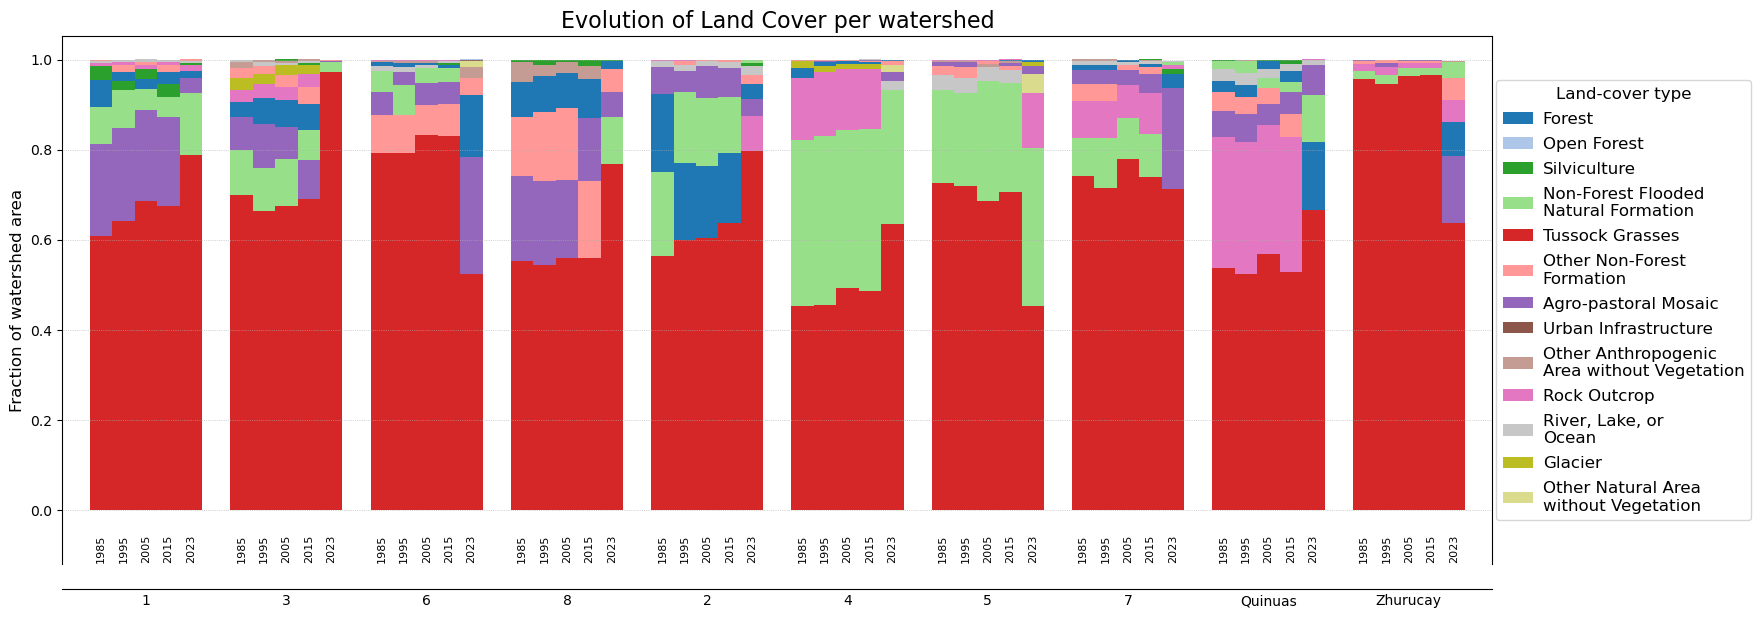

In [8]:
# Example usage

plot_clustered_stacked(
    {
    1985: r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\raw\LC\LC_watersheds_1985.csv",
    1995: r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\raw\LC\LC_watersheds_1995.csv",
    2005: r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\raw\LC\LC_watersheds_2005.csv",
    2015: r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\raw\LC\LC_watersheds_2015.csv",
    2023: r"C:\Users\Jelle Gortemaker\OneDrive - Delft University of Technology\Documenten\0. MSc\MDP\Data\raw\LC\LC_watersheds_2023.csv"
    },
    id_col=0,        # or the column name for watershed ID
    # categories=[...],  # optional: specify which columns to stack; defaults to all numeric columns except id_col
    title="Evolution of Land Cover per watershed"
)
